该文件尝试了将近4天时间，因多进程机制、变量无法随意传递，以及参数debug的不方便，重新安装了eclipse等，和各种异常。因此需要搁置。该代码运行期不应该在notebook上运行，以防止不修改状态下导致的各种异常。

单进程优先测试是通过的状态。该程序应当在eclipse上进行调试。

已经在windows下，使用python多进程的方式，配合multiprocessing的Manager中的队列与Pool，实现了算法本身。现将算法移植到这里。由于model在传入队列中梯度丢失，因此最终从子线程中返回的数据为梯度列表。

编程与测试总耗时大概4小时。该程序编写过程中错误不会及时报出，因此使用Eclipse过程中调试，需要单步测试！

# 导入函数库

In [1]:
import torch
import gym
import numpy as np
import os
import multiprocessing as mp
from multiprocessing import Manager
from multiprocessing import Pool

In [2]:
torch.set_default_dtype(torch.float64)

# MDP记忆

In [3]:
class Stack_queue:
    def __init__(self):
        self.list = []
    
    def get(self):
        o = self.list[-1]
        del self.list[-1]
        return o
    
    def put(self, o):
        self.list.append(o)
    
    def qsize(self):
        return len(self.list)

class memory:
    def __init__(self, env, length=2000, gamma=0.9):
        self.env = env
        self.length = length
        self.gamma = 0.9

        self.state_dimension = self.env.observation_space.shape[0]
        try:self.action_dimension = self.env.action_space.shape[0] 
        except:self.action_dimension = 1
        self.data = Stack_queue()
        
    def put(self, state, action, reward, next_state):
        self.data.put(np.hstack((state, action, reward, next_state)))
        
    def get(self):
        return self.data.get()

    def preprocess(self):
        length_real = self.data.qsize()
        self.state = np.zeros((length_real, self.state_dimension))
        self.action = np.zeros((length_real, self.action_dimension), dtype=np.int64)
        self.reward = np.zeros((length_real, 1))
        self.next_state = np.zeros((length_real, self.state_dimension))
        value_last = 0
        for i in range(length_real)[::-1]:
            transaction = self.data.get()
            state = transaction[:self.state_dimension]
            action = transaction[self.state_dimension:
                                 self.state_dimension+self.action_dimension]
            value = transaction[self.state_dimension+self.action_dimension:
                                                     self.state_dimension+self.action_dimension+1]
            next_state = transaction[-self.state_dimension:]

            value_last = value + self.gamma * value_last
            self.state[i] = state
            self.reward[i] = value_last
            self.action[i] = action
            self.next_state[i] = next_state
            

# Actor网络

In [4]:
class actor:
    def __init__(self, env, hidden_dimension=30, learning_rate=1e-2):
        self.env = env
        self.hidden_dimension = hidden_dimension
        self.learning_rate = learning_rate

        self.state_dimension = self.env.observation_space.shape[0]
        try:self.action_dimension = self.env.action_space.shape[0]
        except:self.action_dimension = self.env.action_space.n

        self.model = self.__create_network()

        self.optimizer = torch.optim.RMSprop(self.model.parameters(), lr=self.learning_rate)
        self.entropy = torch.nn.CrossEntropyLoss(reduction='none')
    
    def learn(self, state, action, advantage):
        state = torch.from_numpy(state)
        action = torch.tensor(action).squeeze()
        advantage = torch.tensor(advantage)
        action_probablity_value = self.model(state)
    
        loss = self.entropy(action_probablity_value, action) * advantage
        loss = torch.mean(loss)
        self.optimizer.zero_grad()
        loss.backward()
        # self.optimizer.step()
        return loss.item(), self.model.parameters()

    def output_action(self, state):
        state = torch.from_numpy(state)
        action_probablity_value = self.model(state)
        action_probablity_value = torch.nn.functional.softmax(action_probablity_value, dim=-1)
        return np.random.choice(np.arange(self.action_dimension),
                                                        p=action_probablity_value.tolist())
        
    def __create_network(self):
        return torch.nn.Sequential(torch.nn.Linear(self.state_dimension, self.hidden_dimension),
                                                             torch.nn.ReLU(),
                                                             torch.nn.Linear(self.hidden_dimension, self.action_dimension)
                                                             )

# Critic网络

In [5]:
class critic:
    def __init__(self, env, hidden_dimension=20, learning_rate=1e-2, gamma=0.9):
        self.env = env
        self.hidden_dimension = hidden_dimension
        self.learning_rate = learning_rate
        self.gamma = gamma

        self.state_dimension = self.env.observation_space.shape[0]
        try:self.action_dimension = self.env.action_space.shape[0]
        except:self.action_dimension = 1

        self.model = self.__create_network()
        self.optimizer = torch.optim.RMSprop(self.model.parameters(), lr=self.learning_rate)

    def learn(self, state, reward, next_state):
        state = torch.from_numpy(state)
        reward = torch.tensor(reward)
        next_state = torch.from_numpy(next_state)

        # value_next = self.model(next_state).detach()
        value = self.model(state)
        advantage = reward - value

        loss = torch.square(advantage)
        loss = torch.mean(loss)

        self.optimizer.zero_grad()
        loss.backward()
        # self.optimizer.step()
        return advantage.tolist(), self.model.parameters()
        
    def __create_network(self):
        return torch.nn.Sequential(torch.nn.Linear(self.state_dimension, self.hidden_dimension),
                                                 torch.nn.ReLU(),
                                                 torch.nn.Linear(self.hidden_dimension,
                                                                  self.action_dimension)
                                                 )

# 智能体交互

In [6]:
class agent_actor_critic(mp.Process):
    def __init__(self, env_name, epoch, q_in, q_out):
        mp.Process.__init__(self)
        self.env_name = env_name
        self.epoch = epoch
        self.q_in = q_in
        self.q_out = q_out
        
        self.env = gym.make(self.env_name)
        self.critic_network = critic(self.env)
        self.actor_network = actor(self.env)
        self.memory = memory(self.env)

    def run(self):
        self.learn()

    def learn(self):
        print('task start, pid: %d'%os.getpid())
        for i in range(self.epoch):
            self.reset_param()
            state = self.env.reset()
            reward_total = 0
            while True:
                action = self.actor_network.output_action(state)
                next_state, reward, done, info = self.env.step(action)
                self.memory.put(state, action ,reward, next_state)
                state = next_state
                reward_total += reward
                if done:
                    # print(reward_total)
                    break
            self.memory.preprocess()
            #self.memory.next_state is NOT used here
            advantage, critic_param = self.critic_network.learn(self.memory.state,
                                                                self.memory.reward,
                                                                self.memory.next_state)
            
            loss, actor_param = self.actor_network.learn(self.memory.state,
                                                         self.memory.action, advantage)
    
            self.update_param()
            #print('reward_total',reward_total)
    
    def reset_param(self):
        critic_net, actor_net = self.q_in.get()
        self.critic_network.model.load_state_dict(
                critic_net.state_dict())
        self.actor_network.model.load_state_dict(
                actor_net.state_dict())

    def update_param(self):
        critic_grad = []
        actor_grad = []
        for each in self.critic_network.model.parameters():
            critic_grad.append(each.grad)
        for each in self.actor_network.model.parameters():
            actor_grad.append(each.grad)
        self.q_out.put((critic_grad,
                        actor_grad))

# 全局智能体

In [7]:
class agent_master(mp.Process):
    def __init__(self, env_name, epoch, work_cnt, q_in, q_out):
        mp.Process.__init__(self)
        self.env = gym.make(env_name)
        self.epoch = epoch
        self.work_cnt = work_cnt
        self.q_in = q_in
        self.q_out = q_out
        
        self.critic_network = critic(self.env)
        self.actor_network = actor(self.env)
    
    def run(self):
        print('master start, pid: %d'%os.getpid())

        for i in range(self.epoch):
            for _ in range(self.work_cnt):
                self.put()
            for _ in range(self.work_cnt):
                self.get()
                
            if (i+1) % 10 == 0:
                self.perform_test(i)
  
    def perform_test(self, i):
        reward_total = 0
        state = self.env.reset()
        while True:
            action = self.actor_network.output_action(state)
            next_state, reward, done, info = self.env.step(action)
            state = next_state
            reward_total += reward
            if done :
                break
        print('%d, performance : reward is %d'%(i, reward_total))

    def put(self):
        self.q_in.put((self.critic_network.model,
                       self.actor_network.model))

    def get(self):
        critic_grad, actor_grad = self.q_out.get()
        
        self.critic_network.optimizer.zero_grad()
        self.actor_network.optimizer.zero_grad()

        for lo_grad, glo_model in zip(critic_grad, 
                                      self.critic_network.model.parameters()):
            glo_model._grad = lo_grad
        for lo_grad, glo_model in zip(actor_grad, 
                                      self.actor_network.model.parameters()):
            glo_model._grad = lo_grad
            
        self.critic_network.optimizer.step()
        self.actor_network.optimizer.step()

# 全局交互测试

In [8]:
class algorithm_a3c:
    def __init__(self, env_name='CartPole-v0', worker_cnt=4, epoch=300):
        self.env_name = env_name
        self.worker_cnt = worker_cnt
        self.epoch = epoch
        
    def start_task(self):
        slaver = agent_actor_critic(self.env_name, self.epoch,
                                    self.q_in, self.q_out)
        slaver.run()
    
    def start_master(self):
        master = agent_master(self.env_name, self.epoch,
                              self.worker_cnt,
                              self.q_in, self.q_out)
        master.run()

    def start_execute(self):
        self.q_in = Manager().Queue()
        self.q_out = Manager().Queue()
        pool = Pool(self.worker_cnt+1)
        for i in range(self.worker_cnt):
            pool.apply_async(self.start_task,
                             args=( ),
                             )
        pool.apply_async(self.start_master,
                         args=( ),
                         )
        pool.close()
        pool.join()
        print('this is the end of the program.')

In [9]:
if __name__ == '__main__':
        torch.set_default_dtype(torch.float64)
        
        algorithm_test = algorithm_a3c()
        algorithm_test.start_execute()

task start, pid: 115
task start, pid: 118
master start, pid: 121
task start, pid: 109
task start, pid: 111
9, performance : reward is 32
19, performance : reward is 121
29, performance : reward is 127
39, performance : reward is 139
49, performance : reward is 122
59, performance : reward is 81
69, performance : reward is 188
79, performance : reward is 119
89, performance : reward is 200
99, performance : reward is 200
109, performance : reward is 200
119, performance : reward is 84
129, performance : reward is 183
139, performance : reward is 156
149, performance : reward is 133
159, performance : reward is 109
169, performance : reward is 152
179, performance : reward is 190
189, performance : reward is 200
199, performance : reward is 200
209, performance : reward is 168
219, performance : reward is 200
229, performance : reward is 200
239, performance : reward is 102
249, performance : reward is 200
259, performance : reward is 175
269, performance : reward is 200
279, performance

In [ ]:
%debug

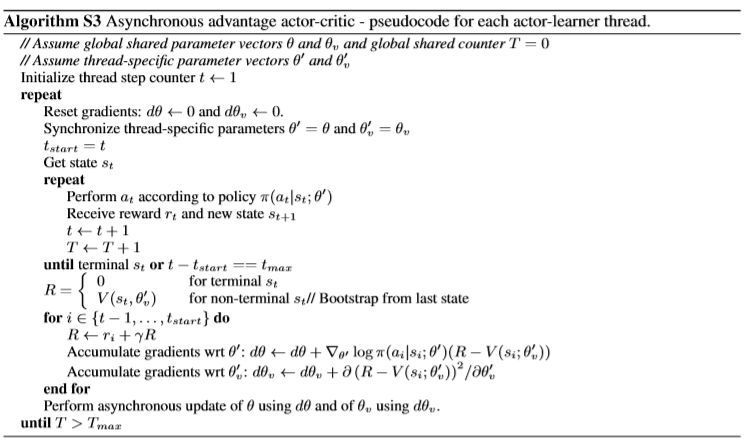

# 多进程工具测试

In [ ]:
class test_config:
  def __init__(self):
    self.a = 1
    self.b = 2
    self.c = 3
  
  def print_a(self):
    print('-----123--------%d'%(self.a))

In [ ]:
import time

In [ ]:
class task1(mp.Process):
  def __init__(self, class_param):
    mp.Process.__init__(self)
    self.task1_a = 11
    self.task1_b = 12
    self.param = class_param
  
  def run(self):
    self.param.print_a(self.param)


cputime=user用户态cpu耗时 +sys内核态cpu耗时

wall time = real time 墙上钟表时间 包含堵塞等多种情况的实际运行时长

In [ ]:
%%time
task_list = []
config = test_config
for i in range(2):
  task = task1(config)
  task_list.append(task)
  task.start()

for each in task_list:
  each.join()

print('execute end!')


In [ ]:
%debug

In [ ]:
from multiprocessing import Process, Value, Lock
from multiprocessing.managers import BaseManager
 
class Employee(object):
    def __init__(self, name, salary):
        self.name = name
        self.salary = Value('i', salary)
        self.data=[]
    def increase(self):
        self.salary.value += 100
        self.data.append(self.salary.value)
        print(self.data)
    def getPay(self):
        return self.name + ':' + str(self.salary.value)

    def getname(self):
        return self.name

def func1(em, lock):
    print(em)
    with lock:
        print(em.getname())
 
manager = BaseManager()
manager.register('Employee', Employee)
manager.start()
em = manager.Employee('zhangsan', 1000)
print(em)
lock = Lock()

proces = [Process(target=func1, args=(em, lock)) for i in range(1)]
for p in proces:
    p.start()
for p in proces:
    p.join()
print(em.getPay())

In [ ]:
! telnet 127.0.0.1 6899

In [ ]:
%px --block
import os
from multiprocessing import Process
from pudb.remote import set_trace

def info(title):
 print(title)
 set_trace()
 print('module name:', __name__)
 print('parent process:', os.getppid())
 print('process id:', os.getpid())

def f(name):
 info('function f')
 print('hello', name)

if __name__ == '__main__':
 info('main line')
 p = Process(target=f, args=('bob',))
 p.start()
 p.join()

In [ ]:
! pip install ipyparallel

# 单进程优先测试

In [ ]:
class agent_actor_critic():
  def __init__(self, env, torch_master):
    self.env = env
    self.torch_master = torch_master

    self.critic_network = critic(self.env)
    self.actor_network = actor(self.env)
    self.memory = memory(self.env)
    self.reset_param()
  
  def run(self):
    self.learn()

  def learn(self):
    state = self.env.reset()
    reward_total = 0
    while True:
      action = self.actor_network.output_action(state)
      next_state, reward, done, info = self.env.step(action)
      self.memory.put(state, action ,reward, next_state)
      state = next_state
      reward_total += reward
      if done:
        break
    self.memory.preprocess()
    advantage, critic_param = self.critic_network.learn(self.memory.state,
                                                       self.memory.reward,
                                                       self.memory.next_state)
    loss, actor_param = self.actor_network.learn(self.memory.state,
                                                 self.memory.action, advantage)

    self.update_param(critic_param, actor_param)
    # print('reward_total',reward_total)
  
  def reset_param(self):
    self.critic_network.model.load_state_dict(
        self.torch_master.get_critic_network().model.state_dict())
    self.actor_network.model.load_state_dict(
        self.torch_master.get_actor_network().model.state_dict())

  def update_param(self, critic_param, actor_param):
    for to_param,from_param in zip(
        self.torch_master.get_critic_network().model.parameters(),critic_param):
      to_param._grad = from_param.grad
    for to_param,from_param in zip(
        self.torch_master.get_actor_network().model.parameters(),actor_param):
      to_param._grad = from_param.grad

class agent_master():
  def __init__(self, env_name):
    self.env = gym.make(env_name)
    self.critic_network = critic(self.env)
    self.actor_network = actor(self.env)
    self.memory = memory(self.env)
  def get_critic_network(self):
    return self.critic_network
  def get_actor_network(self):
    return self.actor_network
  def perform_test(self):
    reward_total = 0
    state = self.env.reset()
    while True:
      action = self.actor_network.output_action(state)
      next_state, reward, done, info = self.env.step(action)
      state = next_state
      reward_total += reward
      if done :
        break
    print('performance : reward is %d'%reward_total)

class algorithm_a3c:
  def __init__(self, env_name='CartPole-v0', epoch=1000):
    self.env_name = env_name
    self.epoch = epoch
  def start_execute(self):
    self.master_data = agent_master(self.env_name)
    for i in range(self.epoch):
      
      self.master_data.get_critic_network().optimizer.zero_grad()
      self.master_data.get_actor_network().optimizer.zero_grad()

      env = gym.make(self.env_name)
      
      self.worker = agent_actor_critic(env, self.master_data)
      self.worker.run()

      self.master_data.get_critic_network().optimizer.step()
      self.master_data.get_actor_network().optimizer.step()
      # import pdb; pdb.set_trace()
      if (i+1) % 10 == 0:
        print('epoch %d'%(i))
        self.master_data.perform_test()


In [ ]:
algorithm_test = algorithm_a3c()
algorithm_test.start_execute()

# 他人测试范例

In [ ]:
import threading
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior
tf.compat.v1.disable_eager_execution()
tf.reset_default_graph()
import numpy as np
import gym
import os
import shutil
import matplotlib.pyplot as plt


GAME = 'CartPole-v0'
OUTPUT_GRAPH = True
LOG_DIR = './log'
N_WORKERS = 1
MAX_GLOBAL_EP = 3000
GLOBAL_NET_SCOPE = 'Global_Net'
UPDATE_GLOBAL_ITER = 100
GAMMA = 0.9
ENTROPY_BETA = 0.001
LR_A = 0.001    # learning rate for actor
LR_C = 0.001    # learning rate for critic
GLOBAL_RUNNING_R = []
GLOBAL_EP = 0
STEP = 3000 # Step limitation in an episode
TEST = 10 # The number of experiment test every 100 episode

env = gym.make(GAME)
N_S = env.observation_space.shape[0]
N_A = env.action_space.n

class ACNet(object):
    def __init__(self, scope, globalAC=None):
        if scope == GLOBAL_NET_SCOPE:   # get global network
            with tf.variable_scope(scope):
                self.s = tf.placeholder(tf.float32, [None, N_S], 'S')
                self.a_params, self.c_params = self._build_net(scope)[-2:]
        else:   # local net, calculate losses
            with tf.variable_scope(scope):
                self.s = tf.placeholder(tf.float32, [None, N_S], 'S')
                self.a_his = tf.placeholder(tf.int32, [None, ], 'A')
                self.v_target = tf.placeholder(tf.float32, [None, 1], 'Vtarget')

                self.a_prob, self.v, self.a_params, self.c_params = self._build_net(scope)

                td = tf.subtract(self.v_target, self.v, name='TD_error')
                with tf.name_scope('c_loss'):
                    self.c_loss = tf.reduce_mean(tf.square(td))

                with tf.name_scope('a_loss'):
                    log_prob = tf.reduce_sum(tf.log(self.a_prob + 1e-5) * tf.one_hot(self.a_his, N_A, dtype=tf.float32), axis=1, keep_dims=True)
                    exp_v = log_prob * tf.stop_gradient(td)
                    entropy = -tf.reduce_sum(self.a_prob * tf.log(self.a_prob + 1e-5),
                                             axis=1, keep_dims=True)  # encourage exploration
                    self.exp_v = ENTROPY_BETA * entropy + exp_v
                    self.a_loss = tf.reduce_mean(-self.exp_v)

                with tf.name_scope('local_grad'):
                    self.a_grads = tf.gradients(self.a_loss, self.a_params)
                    self.c_grads = tf.gradients(self.c_loss, self.c_params)

            with tf.name_scope('sync'):
                with tf.name_scope('pull'):
                    self.pull_a_params_op = [l_p.assign(g_p) for l_p, g_p in zip(self.a_params, globalAC.a_params)]
                    self.pull_c_params_op = [l_p.assign(g_p) for l_p, g_p in zip(self.c_params, globalAC.c_params)]
                with tf.name_scope('push'):
                    self.update_a_op = OPT_A.apply_gradients(zip(self.a_grads, globalAC.a_params))
                    self.update_c_op = OPT_C.apply_gradients(zip(self.c_grads, globalAC.c_params))

    def _build_net(self, scope):
        w_init = tf.random_normal_initializer(0., .1)
        with tf.variable_scope('actor'):
            l_a = tf.layers.dense(self.s, 200, tf.nn.relu6, kernel_initializer=w_init, name='la')
            a_prob = tf.layers.dense(l_a, N_A, tf.nn.softmax, kernel_initializer=w_init, name='ap')
        with tf.variable_scope('critic'):
            l_c = tf.layers.dense(self.s, 100, tf.nn.relu6, kernel_initializer=w_init, name='lc')
            v = tf.layers.dense(l_c, 1, kernel_initializer=w_init, name='v')  # state value
        a_params = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope=scope + '/actor')
        c_params = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope=scope + '/critic')
        return a_prob, v, a_params, c_params

    def update_global(self, feed_dict):  # run by a local
        SESS.run([self.update_a_op, self.update_c_op], feed_dict)  # local grads applies to global net

    def pull_global(self):  # run by a local
        SESS.run([self.pull_a_params_op, self.pull_c_params_op])

    def choose_action(self, s):  # run by a local
        prob_weights = SESS.run(self.a_prob, feed_dict={self.s: s[np.newaxis, :]})
        action = np.random.choice(range(prob_weights.shape[1]),
                                  p=prob_weights.ravel())  # select action w.r.t the actions prob
        return action


class Worker(object):
    def __init__(self, name, globalAC):
        self.env = gym.make(GAME).unwrapped
        self.name = name
        self.AC = ACNet(name, globalAC)

    def work(self):
        global GLOBAL_RUNNING_R, GLOBAL_EP
        total_step = 1
        buffer_s, buffer_a, buffer_r = [], [], []
        while not COORD.should_stop() and GLOBAL_EP < MAX_GLOBAL_EP:
            s = self.env.reset()
            ep_r = 0
            while True:
                a = self.AC.choose_action(s)
                s_, r, done, info = self.env.step(a)
                if done: r = -5
                ep_r += r
                buffer_s.append(s)
                buffer_a.append(a)
                buffer_r.append(r)

                if total_step % UPDATE_GLOBAL_ITER == 0 or done:   # update global and assign to local net
                    if done:
                        v_s_ = 0   # terminal
                    else:
                        v_s_ = SESS.run(self.AC.v, {self.AC.s: s_[np.newaxis, :]})[0, 0]
                    buffer_v_target = []
                    for r in buffer_r[::-1]:    # reverse buffer r
                        v_s_ = r + GAMMA * v_s_
                        buffer_v_target.append(v_s_)
                    buffer_v_target.reverse()

                    buffer_s, buffer_a, buffer_v_target = np.vstack(buffer_s), np.array(buffer_a), np.vstack(buffer_v_target)
                    feed_dict = {
                        self.AC.s: buffer_s,
                        self.AC.a_his: buffer_a,
                        self.AC.v_target: buffer_v_target,
                    }
                    self.AC.update_global(feed_dict)

                    buffer_s, buffer_a, buffer_r = [], [], []
                    self.AC.pull_global()

                s = s_
                total_step += 1
                if done:
                    if len(GLOBAL_RUNNING_R) == 0:  # record running episode reward
                        GLOBAL_RUNNING_R.append(ep_r)
                    else:
                        GLOBAL_RUNNING_R.append(0.99 * GLOBAL_RUNNING_R[-1] + 0.01 * ep_r)
                    print(
                        self.name,
                        "Ep:", GLOBAL_EP,
                        "| Ep_r: %i" % GLOBAL_RUNNING_R[-1],
                          )
                    GLOBAL_EP += 1
                    break

if __name__ == "__main__":
    SESS = tf.Session()

    with tf.device("/cpu:0"):
        OPT_A = tf.train.RMSPropOptimizer(LR_A, name='RMSPropA')
        OPT_C = tf.train.RMSPropOptimizer(LR_C, name='RMSPropC')
        GLOBAL_AC = ACNet(GLOBAL_NET_SCOPE)  # we only need its params
        workers = []
        # Create worker
        for i in range(N_WORKERS):
            i_name = 'W_%i' % i   # worker name
            workers.append(Worker(i_name, GLOBAL_AC))

    COORD = tf.train.Coordinator()
    SESS.run(tf.global_variables_initializer())

    if OUTPUT_GRAPH:
        if os.path.exists(LOG_DIR):
            shutil.rmtree(LOG_DIR)
        tf.summary.FileWriter(LOG_DIR, SESS.graph)

    worker_threads = []
    for worker in workers:
        job = lambda: worker.work()
        t = threading.Thread(target=job)
        t.start()
        worker_threads.append(t)
    COORD.join(worker_threads)

    testWorker = Worker("test", GLOBAL_AC)
    testWorker.AC.pull_global()

    total_reward = 0
    for i in range(TEST):
        state = env.reset()
        for j in range(STEP):
            env.render()
            action = testWorker.AC.choose_action(state)  # direct action for test
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done:
                break
    ave_reward = total_reward / TEST
    print('episode: ', GLOBAL_EP, 'Evaluation Average Reward:', ave_reward)
